In [1]:
import sys
sys.path.append('/Users/pradap/Documents/Research/Python-Package/scaling/dmagellan/')

[########                                ] | 20% Completed |  0.1s

No handlers could be found for logger "py_entitymatching.io.parsers"


[########################################] | 100% Completed |  0.6s
225


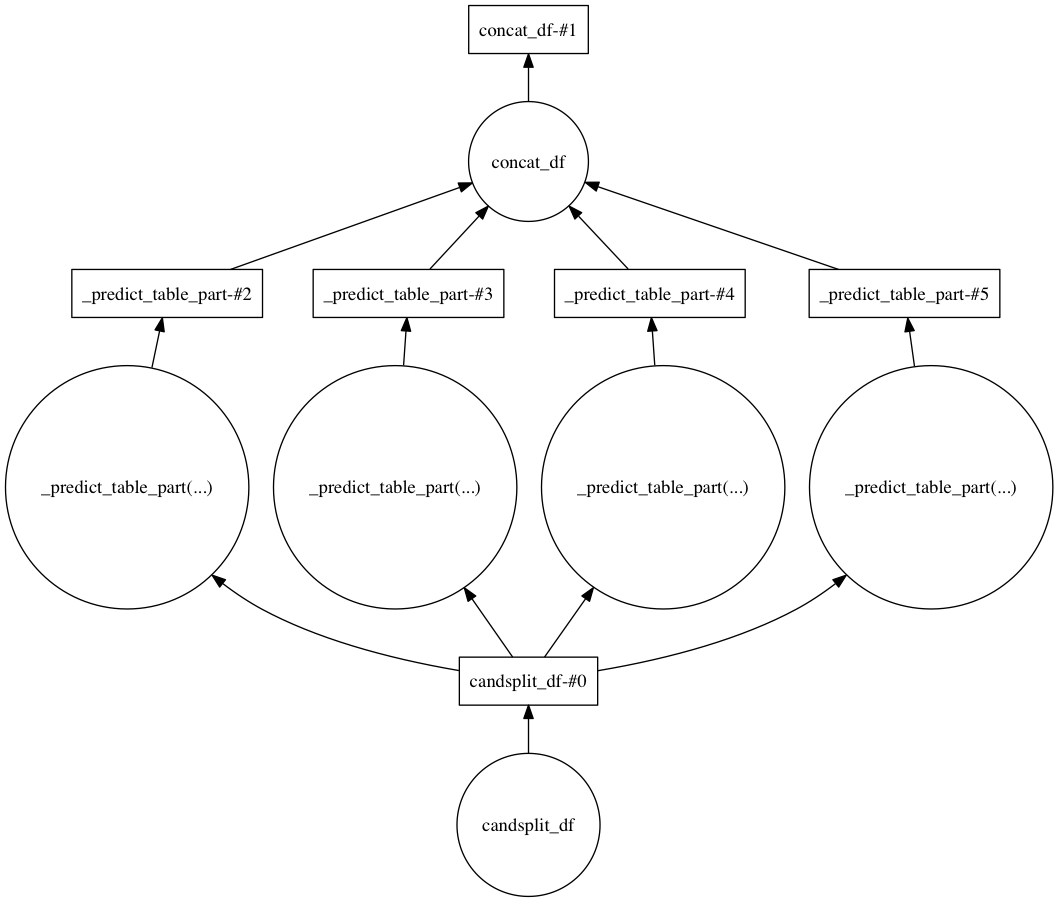

In [2]:
import sys
sys.path.append('/Users/pradap/Documents/Research/Python-Package/anhaid/py_entitymatching')

import py_entitymatching as em
import os

from dask import get
from dmagellan.feature.extractfeatures import extract_feature_vecs
from dmagellan.feature.autofeaturegen import get_features_for_matching
from dmagellan.matcher.dtmatcher import DTMatcher
# imports
import py_entitymatching as em
from dask.sharedict import ShareDict, merge
from dask.dot import dot_graph

from dmagellan.optimization.dictutils import *
from dmagellan.optimization.exfeatvecs_predict_sequence_opt import *

from dmagellan.utils.py_utils.sample_fns import test_create_dag

from dask.optimize import *


# Get the datasets directory
datasets_dir = em.get_install_path() + os.sep + 'datasets'

path_A = datasets_dir + os.sep + 'dblp_demo.csv'
path_B = datasets_dir + os.sep + 'acm_demo.csv'
path_labeled_data = datasets_dir + os.sep + 'labeled_data_demo.csv'


A = em.read_csv_metadata(path_A, key='id')
B = em.read_csv_metadata(path_B, key='id')
# Load the pre-labeled data
S = em.read_csv_metadata(path_labeled_data,
                         key='_id',
                         ltable=A, rtable=B,
                         fk_ltable='ltable_id', fk_rtable='rtable_id')
IJ = em.split_train_test(S, train_proportion=0.5, random_state=0)
I = IJ['train']
J = IJ['test']

F = get_features_for_matching(A, B)
H = extract_feature_vecs(I, A, B, '_id',  'ltable_id', 'rtable_id', 'id', 'id',
                                 feature_table=F, attrs_after='label', nchunks=4,
                                                                    compute=True,
                         scheduler=get)
print(len(H))
# print(L.head())



# Instantiate the matcher to evaluate.
dt = DTMatcher(name='DecisionTree', random_state=0)
# Train using feature vectors from I
dt.fit(table=H,
       exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'],
       target_attr='label')

# Convert J into a set of feature vectors using F
L = extract_feature_vecs(J, A, B, '_id',  'ltable_id', 'rtable_id', 'id', 'id', nchunks=4,
                            feature_table=F, attrs_after='label', show_progress=False,
                         compute=False)

# print(len(L))
# print(L.head(1))
predictions = dt.predict(table=L, exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'],
              append=True, target_attr='predicted', inplace=False, nchunks=4,
                         compute=False)
from dmagellan.optimization.exfeatvecs_predict_sequence_opt import delay_concat, fuse_dag
opt1 = delay_concat(dict(predictions.dask))
opt2 = fuse_dag(opt1)

from dask.dot import dot_graph
dot_graph(opt2)


In [4]:
p = comp_fuse(predictions, [opt2], [opt1])

In [5]:
p.head()

,_id,ltable_id,rtable_id,id_id_lev_dist,id_id_lev_sim,id_id_jar,id_id_jwn,id_id_exm,id_id_jac_qgm_3_qgm_3,title_title_jac_qgm_3_qgm_3,...,authors_authors_cos_dlm_dc0_dlm_dc0,authors_authors_mel,authors_authors_lev_dist,authors_authors_lev_sim,year_year_exm,year_year_anm,year_year_lev_dist,year_year_lev_sim,label,predicted
0,124,l1647,r366,4,0.2,0.483333,0.483333,0,0.000000,0.103093,...,0.00000,0.540816,39.0,0.204082,1,1.0,0.0,1.0,0,0
1,54,l332,r1463,5,0.0,0.000000,0.000000,0,0.000000,0.031915,...,0.00000,0.563757,23.0,0.178571,1,1.0,0.0,1.0,0,0
2,268,l1499,r1725,4,0.2,0.466667,0.466667,0,0.000000,0.042857,...,0.00000,0.515483,114.0,0.142857,1,1.0,0.0,1.0,0,0
3,293,l759,r1749,3,0.4,0.633333,0.633333,0,0.083333,0.402597,...,0.00000,0.833333,2.0,0.750000,1,1.0,0.0,1.0,1,1
4,230,l1580,r1711,4,0.2,0.466667,0.466667,0,0.000000,0.546667,...,0.67082,0.874541,7.0,0.766667,1,1.0,0.0,1.0,1,1
